In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az

In [2]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv", header=0)

# Removing auto measures
auto_measures = [c for c in hoyle_data.columns if c[:2] == "c_"] + ["u_mass_full"]
hoyle_data = hoyle_data.drop(columns = auto_measures)
hoyle_data.head(5).T

# Subsetting by intrusion task
d = hoyle_data[hoyle_data["task"]=="intrusions"].drop(columns="task")

# Adding index to join samples on
d.loc[:, "s_dim_0"] = range(len(d))

In [3]:
## Creating unique identifier for each topic

unique_topic_ids = (d.groupby(["dataset", "model", "topic_idx"], as_index=False)
    .agg({"scores_raw":"count"})
    .drop(columns="scores_raw"))
unique_topic_ids["m_topic"] = unique_topic_ids.index
d1 = pd.merge(d, unique_topic_ids, on=["dataset", "model", "topic_idx"], how="left")

In [4]:
# Setting up numpy arrays for pymc
topics = np.array(d1["m_topic"])
n_topics = d1["m_topic"].nunique()
scores = np.array(d1["scores_raw"])

In [5]:
centered_model = pm.Model()
with centered_model:
    # Hyperparameter priors
    mu_a = pm.Normal("mu_a", mu=0, sigma=1.5)
    sigma_a = pm.Exponential("sigma_a", lam=2) 
    
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_topics)
    p = pm.math.invlogit(a[topics])
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=scores)

    centered_trace=pm.sample(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [6]:
with centered_model:
    centered_prior=pm.sample_prior_predictive(1_000)
    centered_posterior = pm.sample_posterior_predictive(centered_trace)

========================== Trace diagnostics ==========================
Divergent transitions
0    0
1    0
2    0
3    0
dtype: int64


Vars with highest rhat
            a
255  1.007080
225  1.006204
117  1.005953
265  1.005334
272  1.005267


5 variables with lowest effective sample size
               a
26   3321.042857
156  3516.729474
50   3518.603822
187  3525.337547
182  3584.376113


[]

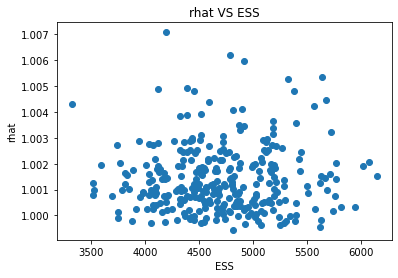

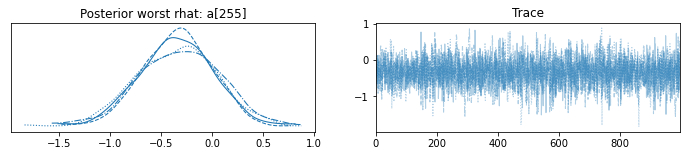

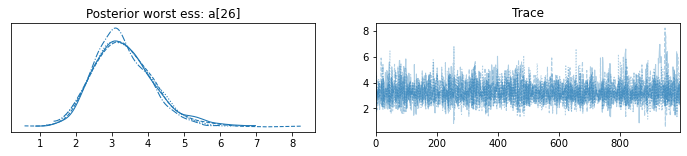

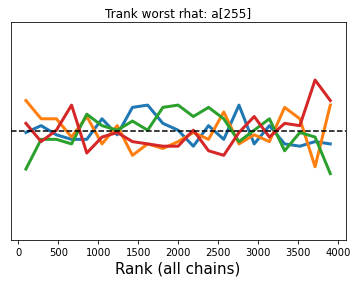

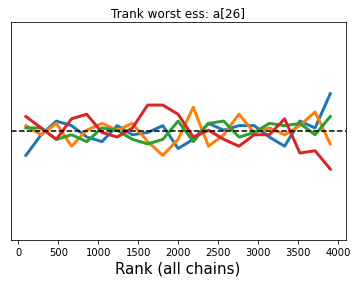

In [12]:
# MCMC Diagnostics
param = "a"
trace = centered_trace

rhat = pd.DataFrame(az.rhat(trace)[param], columns=[param]).sort_values(by=param, ascending=False)[:5]
worst_rhat = rhat.index[0]
ess = pd.DataFrame(az.ess(trace)[param], columns=[param]).sort_values(by=param)[:5]
worst_ess = ess.index[0]


print("========================== Trace diagnostics ==========================")
print("Divergent transitions")
print(pd.DataFrame(trace.sample_stats["diverging"]).T.sum(axis="rows"))
print("\n")
print("Vars with highest rhat")
print(rhat)
print("\n")
print("5 variables with lowest effective sample size")
print(ess)

# Rhat, ESS scatter
fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.scatter(az.ess(trace)[param], az.rhat(trace)[param])
ax1.set_title("rhat VS ESS")
ax1.set_xlabel("ESS")
ax1.set_ylabel("rhat")

# Trace of worst rhat
ax3 = az.plot_trace(trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}), kind="trace")
ax3[0][0].set_title(f"Posterior worst rhat: {param}[{worst_rhat}]")
ax3[0][1].set_title("Trace")

# Trace of worst ess
ax4 = az.plot_trace(trace.posterior[param].sel(**{param+"_dim_0":worst_ess}), kind="trace")
ax4[0][0].set_title(f"Posterior worst ess: {param}[{worst_ess}]")
ax4[0][1].set_title("Trace")

# Trank of worst rhat
ax5 = az.plot_rank(trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax5.set_title(f"Trank worst rhat: {param}[{worst_rhat}]")

# Trank of worst ESS
ax6 = az.plot_rank(trace.posterior[param].sel(**{param+"_dim_0":worst_ess}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax6.set_title(f"Trank worst ess: {param}[{worst_ess}]")

plt.plot()